新建 ai4bio文件夹，把解压后的traindata.csv,trainmap.csv，ai4bio_testset_final 拖动到ai4bio文件夹中
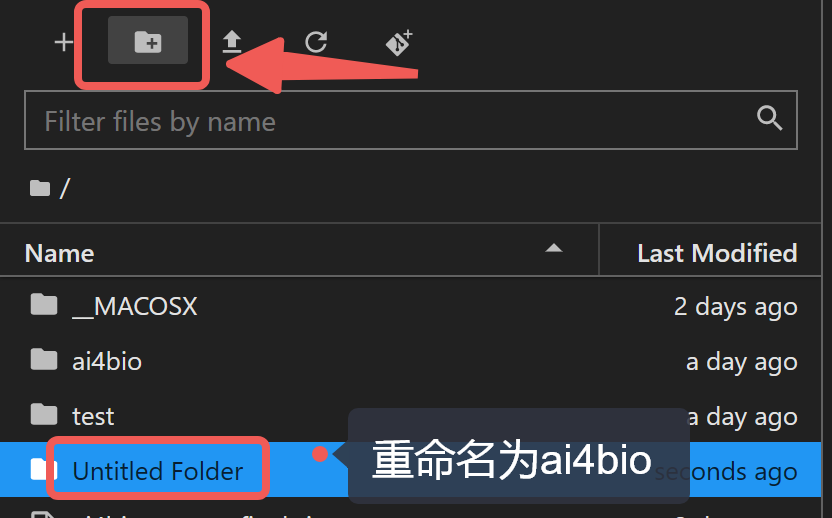

In [1]:
#安装相关库
!pip install lightgbm catboost

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple


In [2]:
#导入模块
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import mean_squared_log_error,mean_absolute_error
import sys,os,gc,argparse,warnings
warnings.filterwarnings('ignore')

In [3]:
#压缩内存函数，本数据过大，算力有限情况下运行该函数可以显著降低内存（50% - 70%），但运行时间极长
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
path = 'ai4bio'

#本次取10000条数据
traindata = pd.read_csv(f'{path}/traindata.csv', nrows=10000)
trainmap = pd.read_csv(f'{path}/trainmap.csv')

testdata = pd.read_csv(f'{path}/ai4bio_testset_final/testdata.csv', nrows=10000)
testmap = pd.read_csv(f'{path}/ai4bio_testset_final/testmap.csv')

#可选择是否运行压缩内存函数
# traindata = reduce_mem_usage(traindata)
# testdata = reduce_mem_usage(testdata)

traindata = traindata.set_index('cpgsite')
traindata = traindata.T
traindata = traindata.reset_index()
traindata = traindata.rename(columns={'index':'sample_id'})
traindata.columns = ['sample_id'] + [i for i in range(10000)]
traindata.to_pickle(f'{path}/traindata_3.pkl')

testdata = testdata.set_index('cpgsite')
testdata = testdata.T
testdata = testdata.reset_index()
testdata = testdata.rename(columns={'index':'sample_id'})
testdata.columns = ['sample_id'] + [i for i in range(10000)]
testdata.to_pickle(f'{path}/testdata_3.pkl')

### 加载已经处理后的数据

In [5]:
trainmap = pd.read_csv(f'{path}/trainmap.csv')
testmap = pd.read_csv(f'{path}/ai4bio_testset_final/testmap.csv')

traindata = pd.read_pickle(f'{path}/traindata_3.pkl')
testdata = pd.read_pickle(f'{path}/testdata_3.pkl')

In [6]:
trainmap.head()

,Unnamed: 0,sample_id,age,gender,sample_type,disease
0,1,train10001,88.0,F,disease tissue,Alzheimer's disease
1,2,train10002,92.0,F,disease tissue,Alzheimer's disease
2,3,train10003,93.0,F,disease tissue,Alzheimer's disease
3,4,train10004,96.0,F,disease tissue,Alzheimer's disease
4,5,train10005,91.0,M,disease tissue,Alzheimer's disease


In [7]:
traindata.head()

,sample_id,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,train10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.322159,-3.659672,-1.191150,-3.837361,-0.422073,-3.175661,0.459845,-3.256540,0.632117,-3.052934
1,train10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.744756,-3.343970,-1.040530,-3.993781,-0.721628,-2.767818,0.614516,-2.842141,0.694497,-3.007447
2,train10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.659672,-3.543689,-0.694497,-3.837361,-0.730728,-3.029956,0.934347,-2.664729,0.672075,-3.124904
3,train10004,NaN,NaN,NaN,NaN,NaN,-1.398461,NaN,NaN,NaN,...,-3.580953,-3.507691,-0.676546,-3.790034,-0.832866,-3.659672,1.336669,-3.701353,0.636532,-3.472874
4,train10005,1.136022,-4.48985,NaN,-3.993781,1.312567,-2.901295,-4.585271,2.804368,2.985388,...,-3.701353,-3.472874,-0.861430,-3.886935,-0.772045,-3.149987,0.472506,-3.076403,0.795272,-3.175661


In [8]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8233 entries, 0 to 8232
Columns: 10001 entries, sample_id to 9999
dtypes: float64(10000), object(1)
memory usage: 628.2+ MB


In [9]:
for i in range(10):
    null_cnt = traindata[i].isnull().sum() / traindata.shape[0]
    print(f'特征{i}，对应的缺失率为{null_cnt}')

特征0，对应的缺失率为0.5364994534191667
特征1，对应的缺失率为0.570144540264788
特征2，对应的缺失率为0.9562735333414308
特征3，对应的缺失率为0.5799829952629662
特征4，对应的缺失率为0.6345196161787927
特征5，对应的缺失率为0.42791206121705333
特征6，对应的缺失率为0.4956880845378355
特征7，对应的缺失率为0.530547795457306
特征8，对应的缺失率为0.5468237580468844
特征9，对应的缺失率为0.5464593708247297


In [10]:
traindata[[i for i in range(1000)]].corr()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,-0.057552,-0.059233,-0.061625,0.027803,-0.055570,-0.029327,0.094735,0.161114,0.067869,...,-0.012111,0.038085,-0.034866,0.128867,0.104127,0.009044,0.084180,-0.049512,-0.015330,0.165752
1,-0.057552,1.000000,0.465775,0.292658,0.430803,0.175303,0.588357,-0.468636,-0.344665,0.006578,...,0.433555,0.514717,0.556725,0.520554,0.203106,0.589371,0.160608,-0.038468,0.564917,0.645022
2,-0.059233,0.465775,1.000000,0.332131,0.431211,0.242769,0.451043,-0.431074,-0.382571,-0.090938,...,0.374844,0.405611,0.384800,0.358097,0.100450,0.398956,0.054686,-0.239749,0.383505,0.226792
3,-0.061625,0.292658,0.332131,1.000000,0.185254,0.010306,0.337439,-0.190723,-0.098594,0.003498,...,0.116259,0.177386,0.246496,0.243776,0.152154,0.230830,-0.048164,-0.014762,0.411772,0.516918
4,0.027803,0.430803,0.431211,0.185254,1.000000,-0.068444,0.365302,-0.369085,-0.307120,-0.075160,...,0.337261,0.219356,0.294232,0.289557,-0.012121,0.330319,0.123923,-0.125072,0.196130,0.285632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.009044,0.589371,0.398956,0.230830,0.330319,0.634110,0.780700,-0.543648,-0.390254,-0.026099,...,0.128975,0.945856,0.761861,0.927760,0.844888,1.000000,0.836557,0.197877,0.914064,0.752402
996,0.084180,0.160608,0.054686,-0.048164,0.123923,0.585911,0.422887,-0.081605,-0.017082,-0.017875,...,0.006400,0.874649,0.702015,0.865072,0.832027,0.836557,1.000000,0.307368,0.829088,0.851129
997,-0.049512,-0.038468,-0.239749,-0.014762,-0.125072,0.447759,-0.048816,0.211162,0.359656,0.056812,...,-0.099045,0.240168,0.441517,0.217693,0.186059,0.197877,0.307368,1.000000,0.261138,0.365846
998,-0.015330,0.564917,0.383505,0.411772,0.196130,0.677450,0.743145,-0.384789,-0.256784,0.030611,...,0.057220,0.932204,0.758244,0.922268,0.849186,0.914064,0.829088,0.261138,1.000000,0.804385


In [11]:
testmap

,Unnamed: 0,sample_id,gender
0,1,test10001,M
1,2,test10002,M
2,3,test10003,F
3,4,test10004,F
4,5,test10005,M
...,...,...,...
2058,2059,test12059,F
2059,2060,test12060,M
2060,2061,test12061,M
2061,2062,test12062,M


In [12]:
# 拼接数据集
traindata = traindata.merge(trainmap[['sample_id', 'age', 'gender', 'sample_type', 'disease']],on='sample_id',how='left')
testdata = testdata.merge(testmap[['sample_id', 'gender']],on='sample_id',how='left')

### 数据清洗

In [13]:
disease_mapping = {
    'control': 0,
    "Alzheimer's disease": 1,
    "Graves' disease": 2,
    "Huntington's disease": 3,
    "Parkinson's disease": 4,
    'rheumatoid arthritis': 5,
    'schizophrenia': 6,
    "Sjogren's syndrome": 7,
    'stroke': 8,
    'type 2 diabetes': 9
}
sample_type_mapping = {'control': 0, 'disease tissue': 1}
gender_mapping = {'F': 0, 'M': 1}

traindata['disease'] = traindata['disease'].map(disease_mapping)
traindata['sample_type'] = traindata['sample_type'].map(sample_type_mapping)
traindata['gender'] = traindata['gender'].map(gender_mapping)

testdata['gender'] = testdata['gender'].map(gender_mapping)

### 构建特征

In [14]:
traindata['max'] = traindata[[i for i in range(10000)]].max(axis=1)
traindata['min'] = traindata[[i for i in range(10000)]].min(axis=1)
traindata['std'] = traindata[[i for i in range(10000)]].std(axis=1)
traindata['var'] = traindata[[i for i in range(10000)]].var(axis=1)
traindata['skew'] = traindata[[i for i in range(10000)]].skew(axis=1)
traindata['mean'] = traindata[[i for i in range(10000)]].mean(axis=1)
traindata['median'] = traindata[[i for i in range(10000)]].median(axis=1)

testdata['max'] = testdata[[i for i in range(10000)]].max(axis=1)
testdata['min'] = testdata[[i for i in range(10000)]].min(axis=1)
testdata['std'] = testdata[[i for i in range(10000)]].std(axis=1)
testdata['var'] = testdata[[i for i in range(10000)]].var(axis=1)
testdata['skew'] = testdata[[i for i in range(10000)]].skew(axis=1)
testdata['mean'] = testdata[[i for i in range(10000)]].mean(axis=1)
testdata['median'] = testdata[[i for i in range(10000)]].median(axis=1)

In [15]:
# 入模特征选择
cols = [i for i in range(10000)] + ['gender','max','min','std','var','skew','mean','median']

### 训练模型

In [16]:
def catboost_model(train_x, train_y, test_x, seed = 2023):
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    oof = np.zeros(train_x.shape[0])
    test_predict = np.zeros(test_x.shape[0])
    cv_scores = []
    
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]
        
        params = {'learning_rate': 0.1,
                  'depth': 5, 
                  'bootstrap_type':'Bernoulli',
                  'random_seed':2023,
                  'od_type': 'Iter', 
                  'od_wait': 100, 
                  'random_seed': 11, 
                  'allow_writing_files': False,
                  'task_type':"GPU",
                  'devices':'0:1'}
        
        
        ##iterations是迭代轮数，可以根据自己的算力与精力，选择合适的轮数，示例给出的是500

        model = CatBoostRegressor(iterations=1000, **params)
        model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                  metric_period=500,
                  use_best_model=True, 
                  cat_features=[],
                  verbose=1)

        val_pred  = model.predict(val_x)
        test_pred = model.predict(test_x)
        
        oof[valid_index] = val_pred
        test_predict += test_pred / kf.n_splits
        
        score = mean_absolute_error(val_y, val_pred)
        cv_scores.append(score)
        print(cv_scores)
        
        # 获取特征重要性打分，便于评估特征
        if i == 0:
            fea_ = model.feature_importances_
            fea_name = model.feature_names_
            fea_score = pd.DataFrame({'fea_name':fea_name, 'score':fea_})
            fea_score = fea_score.sort_values('score', ascending=False)
            fea_score.to_csv('feature_importances.csv', index=False)
        
    return oof, test_predict

In [17]:
cat_oof, cat_test = catboost_model(traindata[cols], traindata['age'], testdata[cols])

************************************ 1 ************************************
0:	learn: 24.0375156	test: 24.3926864	best: 24.3926864 (0)	total: 136ms	remaining: 2m 16s
500:	learn: 4.8413304	test: 6.8165152	best: 6.8165152 (500)	total: 53.2s	remaining: 53s
999:	learn: 3.9018612	test: 6.4931863	best: 6.4931863 (999)	total: 1m 45s	remaining: 0us
bestTest = 6.493186261
bestIteration = 999
[4.606019698546368]
************************************ 2 ************************************
0:	learn: 24.0901667	test: 24.1865936	best: 24.1865936 (0)	total: 129ms	remaining: 2m 9s
500:	learn: 4.8099438	test: 6.8957138	best: 6.8951889 (499)	total: 53.2s	remaining: 53s
999:	learn: 4.0554554	test: 6.6523618	best: 6.6515197 (993)	total: 1m 44s	remaining: 0us
bestTest = 6.651519678
bestIteration = 993
Shrink model to first 994 iterations.
[4.606019698546368, 4.700298968792864]
************************************ 3 ************************************
0:	learn: 24.1113350	test: 24.0413188	best: 24.0413188 (

### 提交结果

In [18]:
testdata['age'] = cat_test
testdata['age'] = testdata['age'].astype(float)
testdata['age'] = testdata['age'].apply(lambda x: x if x>0 else 0.0)
testdata['age'] = testdata['age'].apply(lambda x: '%.2f' % x)
testdata[['sample_id','age']].to_csv('submit_2.txt',index=False)

### 提交结果

下载结果文件至本地

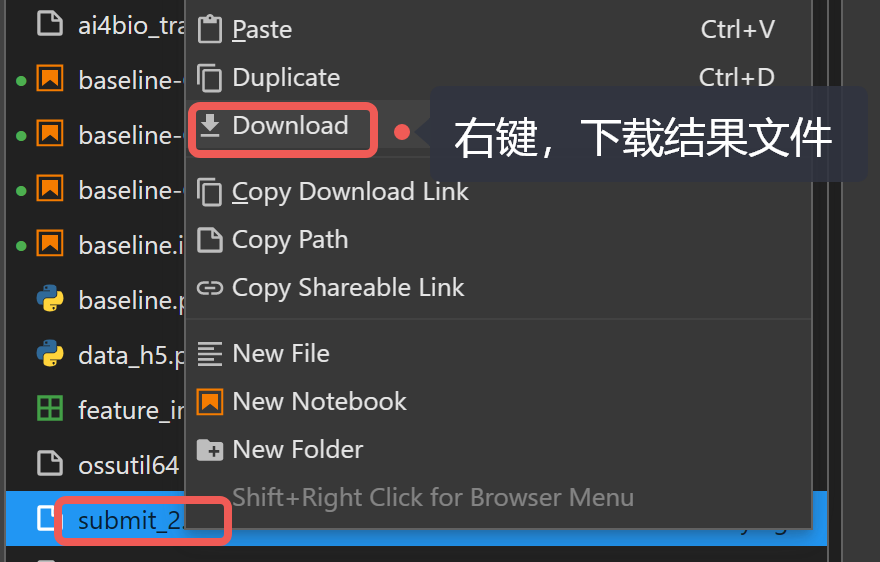

在赛题页面，【提交结果】页面，点击提交结果，上传结果文件，获取分数
https://tianchi.aliyun.com/competition/entrance/532114/submission/1117
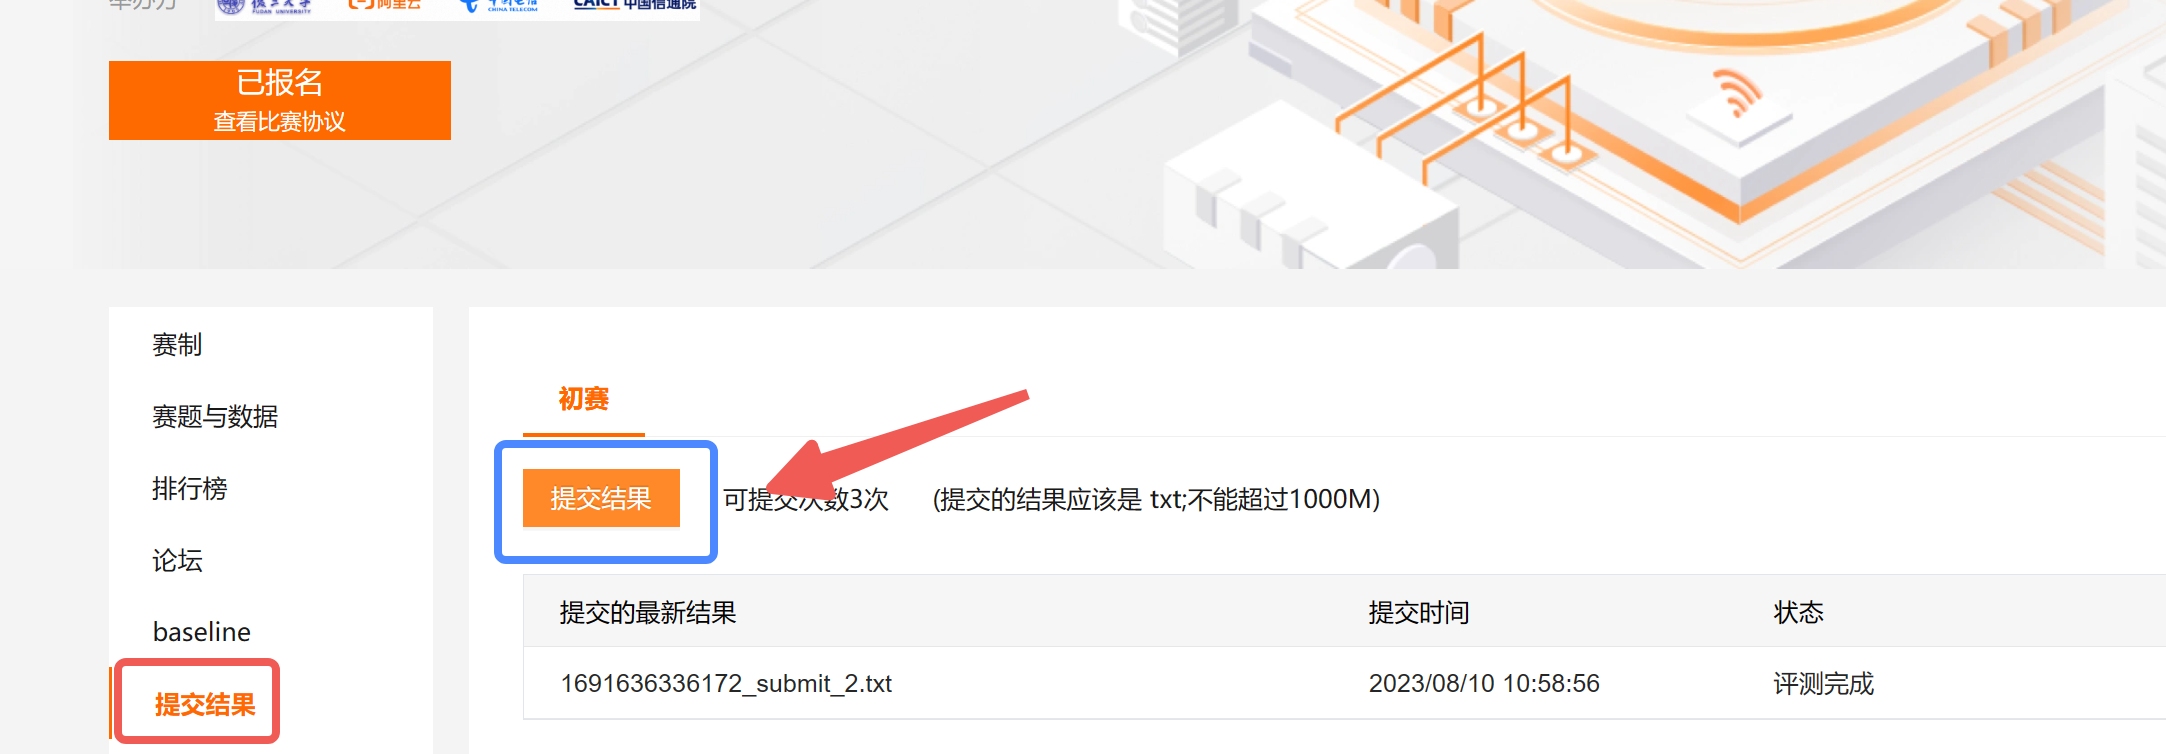